### Load Dataset

In [1]:
from google.colab import files
uploaded = files.upload()

Saving GoogleReview_data_cleaned.csv to GoogleReview_data_cleaned.csv


In [2]:
import pandas as pd

# Replace the filename with your actual uploaded file name if different
df = pd.read_csv("GoogleReview_data_cleaned.csv")

# Preview the first few rows
df.head()


,Author,Rating,Review,Restaurant,Location
0,Jia Pin Lee,4.0,Came here for the High Tea. Great service espe...,Cuisines Restaurant,Ipoh
1,Chui Yi Lum,2.0,"5 stars for the service, even though some of t...",Cuisines Restaurant,Ipoh
2,liezel wong,1.0,"Hi, thank you for your service. But! i feel so...",Cuisines Restaurant,Ipoh
3,Nazri Nor,1.0,I have the worse buffer dinner ever so far. Th...,Cuisines Restaurant,Ipoh
4,Fakru Imran's Channel,5.0,"That's are Known 5 Elmark "" 9H72 "" & KDK "" 3 K...",Cuisines Restaurant,Ipoh


### Build the bipartite graph

In [3]:
import networkx as nx

# Create a new graph
B = nx.Graph()

# Add nodes for reviewers and restaurants
reviewers = df['Author'].unique()
restaurants = df['Restaurant'].unique()

B.add_nodes_from(reviewers, bipartite='reviewer')
B.add_nodes_from(restaurants, bipartite='restaurant')

# Add edges (reviewer → restaurant)
edges = list(zip(df['Author'], df['Restaurant']))
B.add_edges_from(edges)

# Check basic stats
print("Total nodes:", B.number_of_nodes())
print("Total edges:", B.number_of_edges())


Total nodes: 126407
Total edges: 214264


### Project to Reviewer–Reviewer Graph

In [4]:
# Create a projected graph: reviewer-to-reviewer
reviewer_graph = nx.bipartite.weighted_projected_graph(B, reviewers)

# Show basic stats
print("Reviewer–Reviewer Graph Created")
print("Total reviewer nodes:", reviewer_graph.number_of_nodes())
print("Total reviewer-reviewer edges:", reviewer_graph.number_of_edges())


Reviewer–Reviewer Graph Created
Total reviewer nodes: 125150
Total reviewer-reviewer edges: 32144505


### Sample a Subgraph for Testing Louvain

In [5]:
# Take a random sample of 1,000 reviewers
import random

sample_nodes = random.sample(list(reviewer_graph.nodes()), 1000)
subgraph = reviewer_graph.subgraph(sample_nodes).copy()

print("Subgraph created with", subgraph.number_of_nodes(), "nodes and", subgraph.number_of_edges(), "edges")


Subgraph created with 1000 nodes and 2095 edges


### Apply Louvain Community Detection on the Subgraph

In [6]:
# Import Louvain module
!pip install -q python-louvain
import community as community_louvain

# Apply Louvain method
partition = community_louvain.best_partition(subgraph)

# Count number of communities
num_communities = len(set(partition.values()))
print("Louvain clustering done")
print("Total communities found:", num_communities)


Louvain clustering done
Total communities found: 242


### Visualize Reviewer Communities

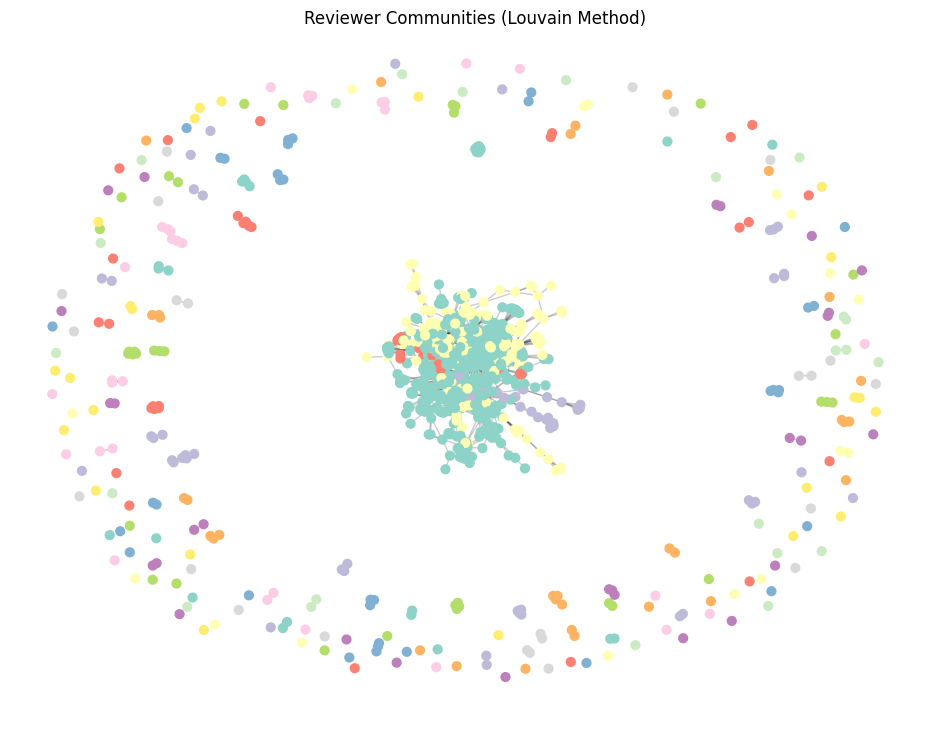

In [7]:
import matplotlib.pyplot as plt

# Assign community as color
colors = [partition[node] for node in subgraph.nodes()]

# Compute graph layout
pos = nx.spring_layout(subgraph, seed=42)

# Plot the graph
plt.figure(figsize=(12, 9))
nx.draw_networkx_nodes(subgraph, pos, node_color=colors, cmap=plt.cm.Set3, node_size=40)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2)
plt.title("Reviewer Communities (Louvain Method)")
plt.axis('off')
plt.show()


### Explore the Largest Reviewer Communities


In [8]:
from collections import Counter

# Count members in each community
community_sizes = Counter(partition.values())

# Show top 5 largest communities
top_communities = community_sizes.most_common(5)
print("Top 5 communities (ID, size):", top_communities)


Top 5 communities (ID, size): [(12, 68), (0, 67), (2, 67), (1, 56), (33, 54)]


### View Reviewers in a Specific Community

In [9]:
# Filter reviewers in Community 12
community_12_members = [node for node, comm in partition.items() if comm == 12]

print("Reviewers in Community 12:")
print(community_12_members[:10])  # Show first 10 as sample
print("Total reviewers in this community:", len(community_12_members))


Reviewers in Community 12:
['Wong Khee Yap', 'V Jun', 'haz fiona', 'ehidibidib', 'cinta ryna', 'Mohamad Khalil Kamarudin', 'Juin Juin', 'Norasikin Md Said', 'eraz tajul', 'Aisyah Zulkarnain']
Total reviewers in this community: 68


### See What Restaurants They Reviewed

In [10]:
# Filter original dataframe for reviews by Community 12 members
community_12_reviews = df[df['Author'].isin(community_12_members)]

# Show top restaurants they reviewed
top_restaurants = community_12_reviews['Restaurant'].value_counts().head(5)

print("Top restaurants reviewed by Community 12:")
print(top_restaurants)


Top restaurants reviewed by Community 12:
Restaurant
Canning Dim Sum          11
Greentown Dimsum Café     9
Plan B (Ipoh)             9
Foh San Restaurant        8
Miker Food                6
Name: count, dtype: int64
